#  Best Model Finding 

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")


#  Load  the Dataset

In [2]:
# Load Dataset
df = pd.read_csv('StudentsPerformance.csv')

# Create target and features
X = df.drop(columns=['math score'])
y = df['math score']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

# Preprocessing pipelines
categorical_transformer = OneHotEncoder(drop='first', sparse=False)
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('num', numerical_transformer, numerical_cols)
    ])

# Apply preprocessing
X = preprocessor.fit_transform(X)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Define Evaluation Function

In [3]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square


### Train and Evaluate Multiple Models

In [4]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso Regression": Lasso(),
    "Ridge Regression": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "AdaBoost": AdaBoostRegressor(random_state=42)
}

model_list = []
train_r2_list = []
test_r2_list = []

for name, model in models.items():
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    _, _, model_train_r2 = evaluate_model(y_train, y_train_pred)
    _, _, model_test_r2 = evaluate_model(y_test, y_test_pred)

    model_list.append(name)
    train_r2_list.append(model_train_r2)
    test_r2_list.append(model_test_r2)

# Create a DataFrame for model performances
performance_df = pd.DataFrame({
    'Model': model_list,
    'Train R2': train_r2_list,
    'Test R2': test_r2_list
}).sort_values(by='Test R2', ascending=False).reset_index(drop=True)

print(performance_df)


                   Model  Train R2   Test R2
0       Ridge Regression  0.874296  0.880451
1      Linear Regression  0.874317  0.880433
2               CatBoost  0.956679  0.850761
3               AdaBoost  0.849052  0.850673
4          Random Forest  0.976073  0.848834
5       Lasso Regression  0.807146  0.825320
6                XGBoost  0.995101  0.825046
7  K-Neighbors Regressor  0.862492  0.776335
8          Decision Tree  0.999653  0.731341


### Train vs Test R2 Comparison

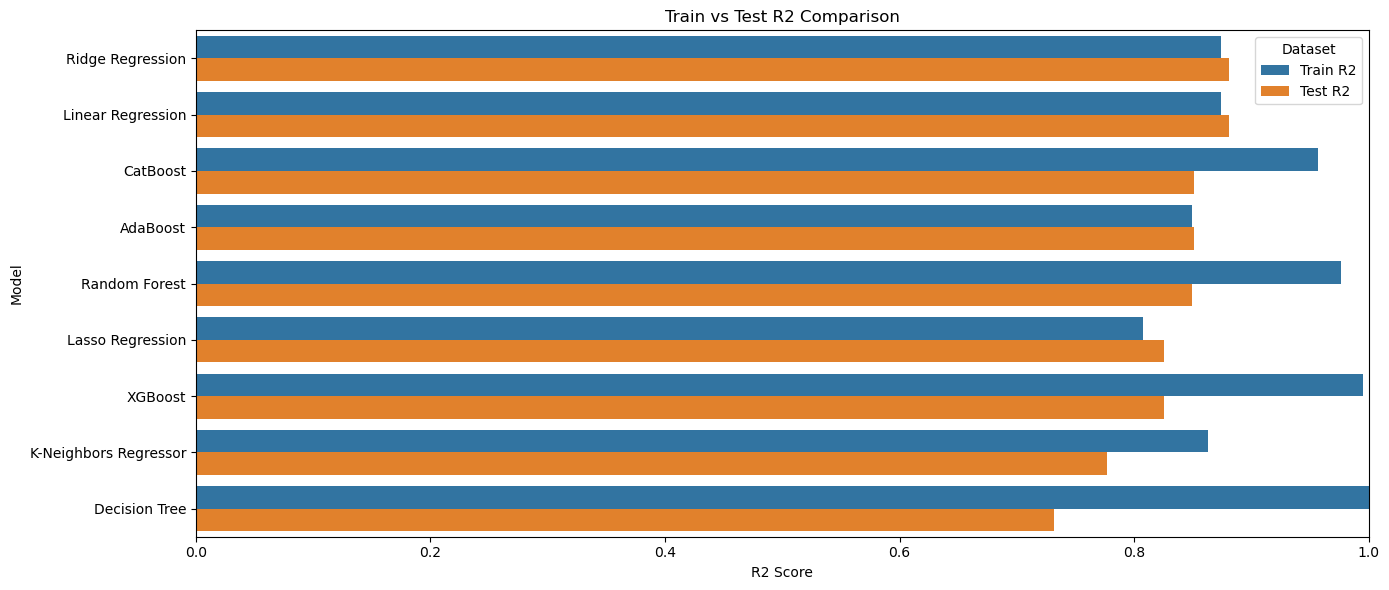

In [5]:
r2_melted = performance_df.melt(id_vars='Model', var_name='Dataset', value_name='R2 Score')

plt.figure(figsize=(14,6))
sns.barplot(x='R2 Score', y='Model', hue='Dataset', data=r2_melted)
plt.title('Train vs Test R2 Comparison')
plt.xlabel('R2 Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()


###  Simple Test R2 Comparison Plot

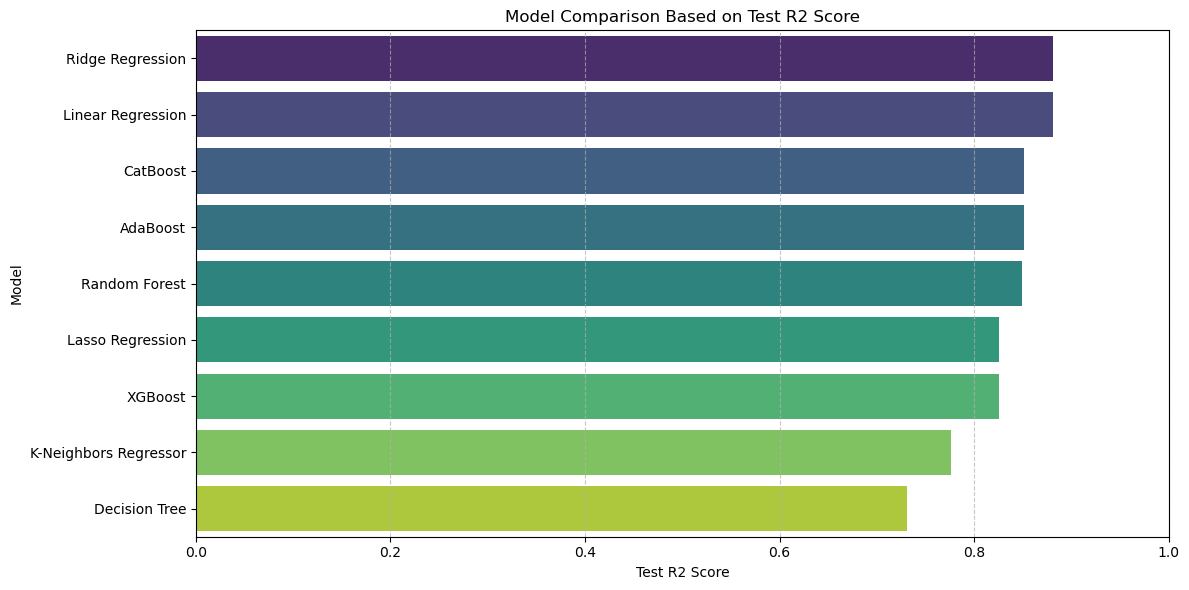

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x='Test R2', y='Model', data=performance_df, palette='viridis')
plt.title('Model Comparison Based on Test R2 Score')
plt.xlabel('Test R2 Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Best Model Insights

In [6]:
# Select best model based on highest Test R2
best_model_name = performance_df.iloc[0]['Model']
print(f"Best Model based on Test R2: {best_model_name}")

best_model = models[best_model_name]
best_model.fit(x_train, y_train)
y_pred_best = best_model.predict(x_test)


Best Model based on Test R2: Ridge Regression


### Residual Analysis for Best Model

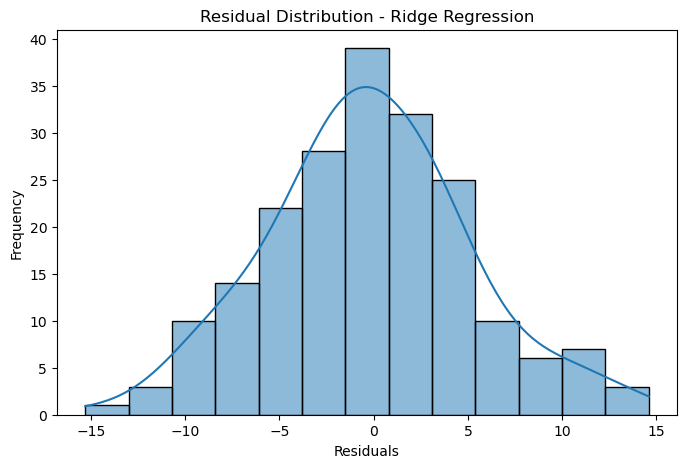

In [7]:
residuals = y_test - y_pred_best

plt.figure(figsize=(8,5))
sns.histplot(residuals, kde=True)
plt.title(f'Residual Distribution - {best_model_name}')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


### Actual vs Predicted Plot for Best Model

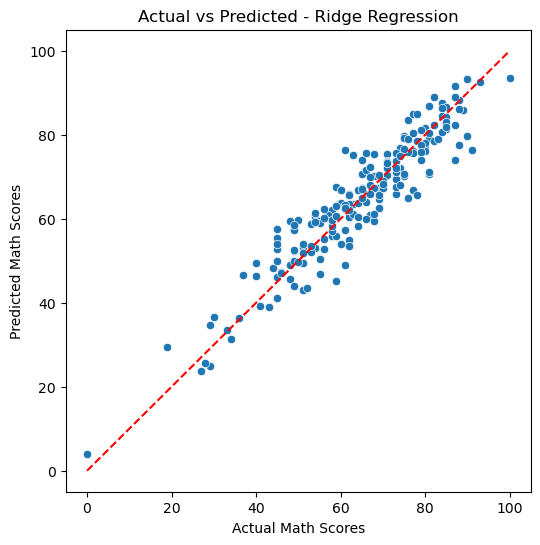

In [8]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=y_test, y=y_pred_best)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.xlabel('Actual Math Scores')
plt.ylabel('Predicted Math Scores')
plt.show()


# 📦 Distribution of Test R2 Scores

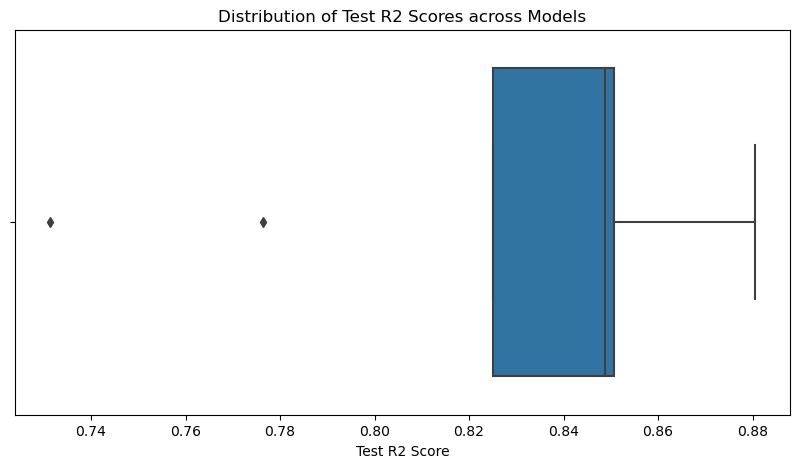

In [9]:
plt.figure(figsize=(10,5))
sns.boxplot(x=test_r2_list)
plt.title('Distribution of Test R2 Scores across Models')
plt.xlabel('Test R2 Score')
plt.show()
